In [1]:
from cgeniepy.foram import ForamModel as fm
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from cgeniepy.foram import scd


mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "Fira Sans"

In [2]:
def dissimilarity(xmodel, xtime, ymodel=None, ytime=None):

    if not ymodel:
        #print("Detecting the same model")
        ymodel = xmodel

    # to avoid "if not zero = True"
    if not ytime and ytime != 0:
        #print("Detecting the same time")
        ytime = xtime

    foram_names = ["bn", "bs", "sn", "ss"]
    x_assem, y_assem = [],[]

    for i, foram in enumerate(foram_names):
        x_state_foram = fm(xmodel).select_foramtype(foram).relative_abundance().isel(time=xtime)
        y_state_foram = fm(ymodel).select_foramtype(foram).relative_abundance().isel(time=ytime)
        x_assem.append(x_state_foram.pure_array())
        y_assem.append(y_state_foram.pure_array())

    # calculate squared chord distance for each model
    assemblage_1 = np.array(x_assem)
    assemblage_2 = np.array(y_assem)
    return scd(assemblage_1, assemblage_2)

def biomass_diff(xmodel, xtime, ymodel=None, ytime=None, percentage=False):
    if not ymodel:
        #print("Detecting the same model")
        ymodel = xmodel

    # to avoid "if not zero = True"
    if not ytime and ytime != 0:
        #print("Detecting the same time")
        ytime = xtime

    foram_names = ["bn", "bs", "sn", "ss"]
    x_assem, y_assem = [],[]

    for foram in foram_names:
        x_state_foram = fm(xmodel).select_foramtype(foram).biomass().isel(time=xtime).sum().magnitude
        y_state_foram = fm(ymodel).select_foramtype(foram).biomass().isel(time=ytime).sum().magnitude
        x_assem.append(x_state_foram)
        y_assem.append(y_state_foram)

    # calculate squared chord distance for each model
    assemblage_1 = np.array(x_assem).sum()
    assemblage_2 = np.array(y_assem).sum()
    diff = assemblage_1 -assemblage_2
    if percentage:
        return diff/assemblage_2 * 100
    else:
        return diff

In [4]:
#biomass_diff(xmodel="../model/muffin.CB.GIteiiva.BASESFeTDTL_rb_foramecogem2.1", xtime=-1,
#             ymodel="../model/worjh2.RpCO2_Rp13CO2.Albani.0ka.historical", ytime=-1, percentage=True) -> 50% change

dissimilarity(xmodel="../model/muffin.CB.GIteiiva.BASESFeTDTL_rb_foramecogem2.1", xtime=-1,
             ymodel="../model/worjh2.RpCO2_Rp13CO2.Albani.0ka.historical", ytime=-1).nanmean()

0.31975055

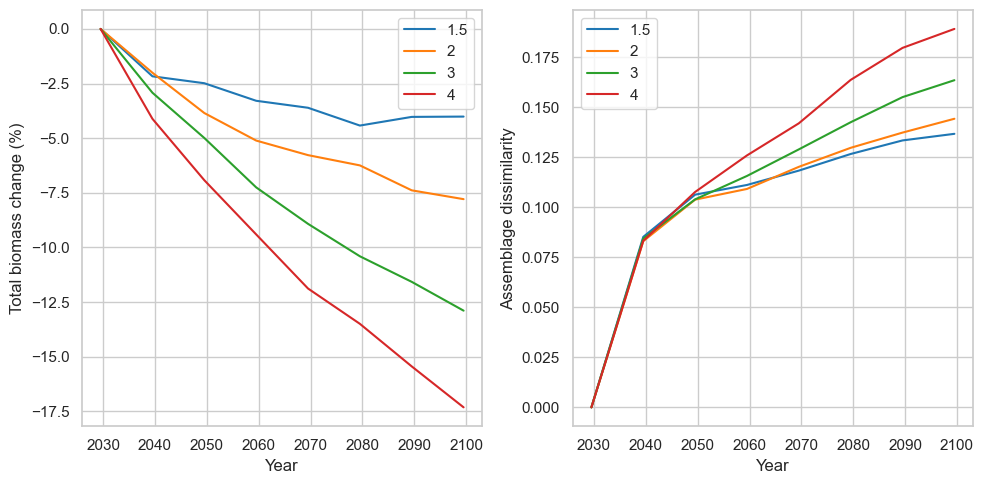

In [5]:
mod_paths = [
    "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.1p5deg",
    "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.2deg",
    "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.3deg",
    "../model/worjh2.RpCO2_Rp13CO2.Albani.2100.4deg",
]

# Cumulative dissimilarity
sns.set_theme()
sns.set_style("whitegrid")
colors = sns.color_palette("tab10", 4)

dtemp = ["1.5", "2", "3", "4"]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)

for i, ipath in enumerate(mod_paths):
    dis = []
    biomass = []
    time_label = fm(ipath).select_var("time").array.values
    # print 2000 year and afterwards
    for j in range(len(time_label)):
        dis.append(dissimilarity(xmodel=ipath, xtime=0, ytime=j).nanmean())
        biomass.append(biomass_diff(xmodel=ipath, xtime=j, ytime=0, percentage=True))
    dis = np.array(dis)
    biomass = np.array(biomass)
    ax1.plot(time_label, biomass, label=dtemp[i], color=colors[i], linewidth=1.5)
    ax2.plot(time_label, dis, label=dtemp[i], color=colors[i], linewidth=1.5)

ax1.legend()
ax2.legend()
ax1.set_xlabel("Year")
ax2.set_xlabel("Year")
#ax1.set_ylabel("Total biomass change (Gt C)")
ax1.set_ylabel("Total biomass change (%)")
ax2.set_ylabel("Assemblage dissimilarity")
fig.savefig("../output/assemblage_change.png", dpi=300)